[ 46  10 204  84 184 195 171 208  93  48 121 155   9   7   6 122  86 189
  38 152 188  92 198  97  76 158 211 199   5  55  67  96 113 133 187  71
 149  70  47  61 127 135 162  95 160 130 103 205  58  81 144 161   2 129
 126 101  69  64 111 221 194  12 168 128  53 148  42  32  65 141 106  89
 124 146  16  50 147   8  40 104  90 119 183 203 108 190 213  31 140 105
  79  62 157 185 217 167 200 210 137 176  49 220  63  82 180 192 219   0
 218 115 142  19 209 107  74  36  41 186 216 173  33 110 182  35 165  20
 172 201 164 150  39  52 179 116 181 178 131  17  13 191 145 222  78 224
 223 215  11  15 151 177  87  88 132  26  29 174  60  85  14 139  98  77
  30 197 109 102  22  23 214  27  72 207 114  57  75  56  73 154  25  51
  94  54  45 163  80  28  43  37 136  83  66  24 120   4  68 175  99 138
 206   1 169 112 100  91 166  21 212 123 170 196 193 143  59 159 118  34
 117   3 156 134 202 125  18  44 153]
839.1048845448784 904.9703037081866 65.86541916330827
12.931761733972 22.7522516215920

2025-09-18 09:40:29.459562: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[ 46  10 204  84 184 195 171 208  93  48 121 155   9   7   6 122  86 189
  38 152 188  92 198  97  76 158 211 199   5  55  67  96 113 133 187  71
 149  70  47  61 127 135 162  95 160 130 103 205  58  81 144 161   2 129
 126 101  69  64 111 221 194  12 168 128  53 148  42  32  65 141 106  89
 124 146  16  50 147   8  40 104  90 119 183 203 108 190 213  31 140 105
  79  62 157 185 217 167 200 210 137 176  49 220  63  82 180 192 219   0
 218 115 142  19 209 107  74  36  41 186 216 173  33 110 182  35 165  20
 172 201 164 150  39  52 179 116 181 178 131  17  13 191 145 222  78 224
 223 215  11  15 151 177  87  88 132  26  29 174  60  85  14 139  98  77
  30 197 109 102  22  23 214  27  72 207 114  57  75  56  73 154  25  51
  94  54  45 163  80  28  43  37 136  83  66  24 120   4  68 175  99 138
 206   1 169 112 100  91 166  21 212 123 170 196 193 143  59 159 118  34
 117   3 156 134 202 125  18  44 153]
839.1048845448784 904.9703037081866 65.86541916330827
12.931761733972 22.7522516215920

/var/folders/yr/sm3l0swn5gqbc75_wt24rvy80000gn/T/ipykernel_84730/1956741095.py:73: UserWarning: You passed a edgecolor/edgecolors ('#0072B2') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(t_j, r[idx], marker='x', s=s_cross, alpha=1.0,
/var/folders/yr/sm3l0swn5gqbc75_wt24rvy80000gn/T/ipykernel_84730/1956741095.py:73: UserWarning: You passed a edgecolor/edgecolors ('#D55E00') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(t_j, r[idx], marker='x', s=s_cross, alpha=1.0,


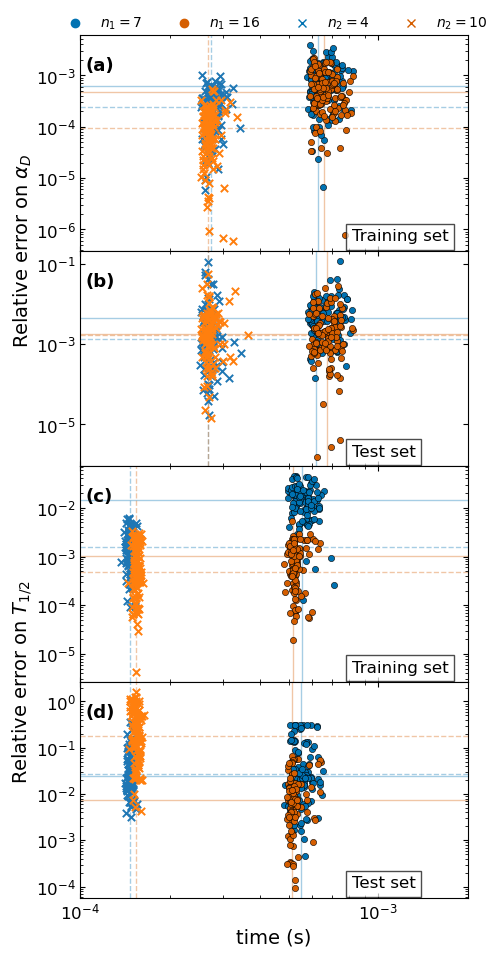

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import re, os, sys
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))
from Beta_decay import helper as beta_helper
from dipoles_exp_param import helper as dipole_helper

# ---------- global style ----------
plt.rcParams.update({
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.top": True, "ytick.right": True,
    "xtick.minor.visible": True, "ytick.minor.visible": True,
    "xtick.labelsize": 12, "ytick.labelsize": 12,
    "axes.titlesize": 14, "axes.labelsize": 14,
})

# Custom (Okabe–Ito) palettes — NOT Matplotlib default
dipole_cols = ["#0072B2", "#D55E00", "#CC79A7"]   # blue, vermillion, purple
beta_cols   = ["#0072B2", "#D55E00", "#CC79A7"]  # green, orange, sky blue

# ---------- helpers ----------
def load_train_set(path_txt):
    with open(path_txt, "r") as f:
        return [tuple(map(str, line.strip().split(","))) for line in f]

def centroid_like_point(train_set):
    arr = np.array(train_set, float)
    centroid = arr.mean(axis=0)
    idx = np.argmin(np.linalg.norm(arr - centroid, axis=1))
    return train_set[idx]

def bbox_midpoint_point(train_set):
    Amin = min(float(a) for a, b in train_set)
    Amax = max(float(a) for a, b in train_set)
    Bmin = min(float(b) for a, b in train_set)
    Bmax = max(float(b) for a, b in train_set)
    cx, cy = (Amin + Amax) / 2.0, (Bmin + Bmax) / 2.0
    return min(train_set, key=lambda t: (float(t[0]) - cx)**2 + (float(t[1]) - cy)**2)

def log_jitter(x, sigma=0.02, seed=0):
    rng = np.random.default_rng(seed)
    return np.asarray(x) * np.exp(rng.normal(0.0, sigma, size=len(x)))

def split_train_test(combined, train_set):
    mask_train = np.array([pt in train_set for pt in combined], dtype=bool)
    idx_train = np.nonzero(mask_train)[0]
    idx_test  = np.nonzero(~mask_train)[0]
    return idx_train, idx_test

def maybe_subsample(idx, max_points=None, seed=0):
    if (max_points is None) or (len(idx) <= max_points):
        return idx
    rng = np.random.default_rng(seed)
    return np.sort(rng.choice(idx, size=max_points, replace=False))

def scatter_panel(ax, times, rel, idx, *, color, marker,
                  s_circle=20, s_cross=28, lw_cross=1.2,
                  jitter_sigma=0.02, jitter_seed=0, rasterized=True, label=None):
    if len(idx) == 0: return
    t = np.asarray(times, float); r = np.asarray(rel, float); idx = np.asarray(idx)
    t_j = log_jitter(t[idx], sigma=jitter_sigma, seed=jitter_seed)
    if marker == 'o':  # Alg 1
        ax.scatter(t_j, r[idx], marker='o', s=s_circle, alpha=1.0,
                   facecolors=color, edgecolors="k", linewidths=0.4,
                   zorder=3, rasterized=rasterized, label=label)
    else:              # Alg 2 (bold ×)
        ax.scatter(t_j, r[idx], marker='x', s=s_cross, alpha=1.0,
                   edgecolors=color, linewidths=lw_cross,
                   zorder=4, rasterized=rasterized, label=label)

def add_median_guides(ax, times, rel, idx, color, ls='-'):
    if len(idx) == 0: return
    t_med = float(np.median(np.asarray(times)[idx]))
    r_med = float(np.median(np.asarray(rel)[idx]))
    ax.axvline(t_med, color=color, ls=ls, lw=1.0, alpha=0.35, zorder=1)
    ax.axhline(r_med, color=color, ls=ls, lw=1.0, alpha=0.35, zorder=1)

def tag_panel(ax, tag):
    ax.text(0.012, 0.9, tag, transform=ax.transAxes,
            va='top', ha='left', fontsize=13, fontweight='bold')

def annotate_row(ax, text):
    ax.text(0.7, 0.1, text, transform=ax.transAxes,
            ha="left", va="top", fontsize=12,
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.7))

# ---------- Dipole (α_D) ----------
def compute_dipole_data():
    train_set = load_train_set("../dipoles_exp_param/train_set.txt")
    central_point = bbox_midpoint_point(train_set)

    strength_dir = '../dipoles_data_all/total_strength/'
    alphaD_dir   = '../dipoles_data_all/total_alphaD/'
    pattern = re.compile(r'^strength_([0-9.]+)_([0-9.]+)\.out$')

    combined = []
    for fname in os.listdir(strength_dir):
        m = pattern.match(fname)
        if not m: continue
        beta, alpha = m.group(1), m.group(2)
        if os.path.exists(os.path.join(alphaD_dir, f'alphaD_{beta}_{alpha}.out')):
            combined.append((alpha, beta))

    idx_train, idx_test = split_train_test(combined, train_set)

    # Alg 1
    retain = 0.6
    em1 = []
    for n in [7, 16]:
        params = np.loadtxt(f'../dipoles_exp_param/params_{n}_{retain}.txt').astype(np.float32)
        alphaD, alphaD_test, times = dipole_helper.plot_alphaD(combined, params, n, central_point, retain)
        rel = np.abs(np.array(alphaD_test) - np.array(alphaD)) / np.array(alphaD_test)
        em1.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    # Alg 2
    em2 = []
    for n in [4, 10]:
        params = np.loadtxt(f'../dipoles_exp_param/params_{n}_only_alphaD.txt').astype(np.float32)
        alphaD, alphaD_test, times = dipole_helper.plot_alphaD_simple(combined, params, n, central_point)
        rel = np.abs(np.array(alphaD_test) - np.array(alphaD)) / np.array(alphaD_test)
        em2.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    return dict(combined=combined, idx_train=idx_train, idx_test=idx_test,
                em1=em1, em2=em2)

def plot_dipole_row(ax_train, ax_test, data):
    idx_train, idx_test = data["idx_train"], data["idx_test"]
    idx_test_sub = maybe_subsample(idx_test, max_points=None, seed=11)

    # Alg 1 (filled circles)
    for i, d in enumerate(data["em1"]):
        c = dipole_cols[i]
        scatter_panel(ax_train, d["times"], d["rel"], idx_train,
                      color=c, marker='o', jitter_seed=100 + d["n"])
        add_median_guides(ax_train, d["times"], d["rel"], idx_train, c, ls='-')
        scatter_panel(ax_test,  d["times"], d["rel"], idx_test_sub,
                      color=c, marker='o', jitter_seed=120 + d["n"])
        add_median_guides(ax_test,  d["times"], d["rel"], idx_test,  c, ls='-')

    # Alg 2 (×)
    for i, d in enumerate(data["em2"]):
        c = dipole_cols[i]  # shift so it’s distinct from Alg1
        scatter_panel(ax_train, d["times"], d["rel"], idx_train,
                      color=c, marker='x', jitter_seed=200 + d["n"], lw_cross=1.4)
        add_median_guides(ax_train, d["times"], d["rel"], idx_train, c, ls='--')
        scatter_panel(ax_test,  d["times"], d["rel"], idx_test_sub,
                      color=c, marker='x', jitter_seed=220 + d["n"], lw_cross=1.4)
        add_median_guides(ax_test,  d["times"], d["rel"], idx_test,  c, ls='--')

    for ax in (ax_train, ax_test):
        ax.set_yscale('log'); #ax.grid(alpha=0.25, which='both')
    ax_train.set_ylabel(r"Relative error on $\alpha_D$")
    ax_train.yaxis.set_label_coords(-0.12, 0.0)
    #ax_train.set_title("Train region"); ax_test.set_title("Test region")
    annotate_row(ax_train, "Training set")
    annotate_row(ax_test,  "Test set")

# ---------- Beta decay (T1/2) ----------
def compute_beta_data():
    A, Z, g_A, nucnam = 80, 28, 1.2, "Ni_80"
    coeffs = Polynomial(beta_helper.fit_phase_space(0, Z, A, 15)).coef

    train_set = load_train_set("../Beta_decay/train_set.txt")
    central_point = centroid_like_point(train_set)

    strength_dir = f'../beta_decay_data_{nucnam}/'
    pattern = re.compile(rf'^lorm_{nucnam}_([0-9.]+)_([0-9.]+)\.out$')

    combined = []
    for fname in os.listdir(strength_dir):
        m = pattern.match(fname)
        if m:
            beta_val, alpha_val = m.group(1), m.group(2)
            combined.append((alpha_val, beta_val))

    idx_train, idx_test = split_train_test(combined, train_set)

    # Alg 1
    em1 = []
    for n in [7, 16]:
        params = np.loadtxt(f'../Beta_decay/params_{n}_0.9.txt')
        HLs, HLs_test, times = beta_helper.plot_half_lives(combined, params, n, coeffs, g_A, central_point, nucnam, 0.9)
        rel = np.abs(np.array(HLs_test) - np.array(HLs)) / np.array(HLs_test)
        em1.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    # Alg 2
    em2 = []
    for n in [5, 14]:
        params = np.loadtxt(f'../Beta_decay/params_{n}_only_HL.txt')
        HLs, HLs_test, times = beta_helper.plot_half_lives_only_HL(combined, params, n, coeffs, g_A, central_point, nucnam)
        rel = np.abs(np.array(HLs_test) - np.array(HLs)) / np.array(HLs_test)
        em2.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    return dict(combined=combined, idx_train=idx_train, idx_test=idx_test,
                em1=em1, em2=em2)

def plot_beta_row(ax_train, ax_test, data):
    idx_train, idx_test = data["idx_train"], data["idx_test"]
    idx_test_sub = maybe_subsample(idx_test, max_points=None, seed=21)

    # Alg 1 (filled circles)
    for i, d in enumerate(data["em1"]):
        c = beta_cols[i]
        scatter_panel(ax_train, d["times"], d["rel"], idx_train,
                      color=c, marker='o', jitter_seed=300 + d["n"])
        add_median_guides(ax_train, d["times"], d["rel"], idx_train, c, ls='-')
        scatter_panel(ax_test,  d["times"], d["rel"], idx_test_sub,
                      color=c, marker='o', jitter_seed=320 + d["n"])
        add_median_guides(ax_test,  d["times"], d["rel"], idx_test,  c, ls='-')

    # Alg 2 (×)
    for i, d in enumerate(data["em2"]):
        c = beta_cols[i]
        scatter_panel(ax_train, d["times"], d["rel"], idx_train,
                      color=c, marker='x', jitter_seed=400 + d["n"], lw_cross=1.4)
        add_median_guides(ax_train, d["times"], d["rel"], idx_train, c, ls='--')
        scatter_panel(ax_test,  d["times"], d["rel"], idx_test_sub,
                      color=c, marker='x', jitter_seed=420 + d["n"], lw_cross=1.4)
        add_median_guides(ax_test,  d["times"], d["rel"], idx_test,  c, ls='--')

    for ax in (ax_train, ax_test):
        ax.set_yscale('log'); #ax.grid(alpha=0.25, which='both')
    ax_train.set_ylabel(r"Relative error on $T_{1/2}$")
    ax_train.yaxis.set_label_coords(-0.12, 0.0)
    #ax_train.set_title("Train region"); ax_test.set_title("Test region")
    annotate_row(ax_train, "Training set")
    annotate_row(ax_test,  "Test set")

# ---------- 4×1 layout with tags and shared x ----------
def main():
    fig, axes = plt.subplots(4, 1, figsize=(5, 11.2), sharex=True,
                             gridspec_kw={"hspace": 0.0})
    ax_a, ax_b, ax_c, ax_d = axes

    dipole_data = compute_dipole_data()
    plot_dipole_row(ax_a, ax_b, dipole_data)

    beta_data = compute_beta_data()
    plot_beta_row(ax_c, ax_d, beta_data)

    # Shared x-axis for ALL panels
    x_min, x_max = 1e-4, 2e-3
    for ax in axes:
        ax.set_xscale('log'); ax.set_xlim(x_min, x_max)

    # Panel tags
    tag_panel(ax_a, "(a)"); tag_panel(ax_b, "(b)")
    tag_panel(ax_c, "(c)"); tag_panel(ax_d, "(d)")

    # Single xlabel for the whole figure
    axes[3].set_xlabel("time (s)", fontsize=14)

    # Compact legends outside axes
    from matplotlib.lines import Line2D
    handles_dip = [Line2D([], [], marker='o', linestyle='None', color=dipole_cols[i], label=f"$n_1={n}$")
                   for i, n in enumerate([7, 16])]
    handles_dip += [Line2D([], [], marker='x', linestyle='None', color=dipole_cols[i], label=f"$n_2={n}$")
                    for i, n in enumerate([4, 10])]

    axes[0].legend(handles=handles_dip, loc="upper center", ncol=5,
               bbox_to_anchor=(0.5, 1.15), frameon=False)


    plt.savefig("CATPlot.pdf", bbox_inches="tight")
    plt.subplots_adjust(hspace = 0.0)
    plt.show()

if __name__ == "__main__":
    main()
